## RunModels_ForEachOf7Clusters
This script:
- Reads in the per-LSOA embedding summary pickle produced by script 7. This contains, for each LSOA, the mean/median/min/max embedding for each cluster, plus cluster image counts and percentages. The `statistic` variable below selects which summary statistic to use (default: median).
- Joins to IMD ranking data
- For each of the 7 clusters, trains an XGBoost model using only that cluster's embedding as features, with a simple 80/20 train-test split
- Compares model performance (R², RMSE, Spearman correlation) across clusters

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from sklearn.base import clone
import matplotlib.pyplot as plt
import joblib

def evaluate_imd_model(y_true, y_pred, column, num_in_class, num_lsoas, plot=True, plot_collectively=False, ax=False):
    """Evaluate model predictions against true IMD values."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Spearman_rank_corr': spearman_corr}

    if plot:
        plt.figure(figsize=(6, 6))
        plt.scatter(y_true, y_pred, alpha=1)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        plt.xlabel(f"True {column}")
        plt.ylabel(f"Predicted {column}")
        plt.title(f"{column}")
        plt.grid(True)
        plt.show()

    if plot_collectively:
        ax.scatter(y_true, y_pred, alpha=1, marker='.', s=70)
        ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        ax.set_xlabel(f"True")
        ax.set_ylabel(f"Predicted")
        ax.set_title(f"{column}: \n{num_in_class} images\n {num_lsoas} LSOAs", fontsize=15)
        ax.grid(True)
        ax.text(
            0.01, 0.99,
            f'R² = {r2:.2f}, RMSE = {rmse:.0f}',
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment='top',
            horizontalalignment='left')

    return metrics

In [2]:
from directory_filepaths import *

In [3]:
# Number of clusters
k = 4

In [4]:
# Variable being modelled
var_to_predict = 'imd_rank'

# Which summary statistic to use for the per-cluster embeddings
# (script 7 saves mean, median, min, max — change this to try others)
statistic = 'median'

In [5]:
best_model = joblib.load(os.path.join(data_dir, "best_model/best_model.joblib"))['model']

### Get imd data

In [6]:
imd = pd.read_excel(imd_file, sheet_name="IoD2025 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {"LSOA code (2021)": "LSOA21CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)

### Get embedding data

In [7]:
# Load per-LSOA embedding summaries from script 7
# (contains mean/median/min/max embedding per cluster, counts, and percentages)
summary_df = pd.read_pickle(os.path.join(data_dir, "per_lsoa_embedding_summaries", "median_embedding_per_cluster.pkl"))

# Join IMD data and create a re-ranked variable (ranks only LSOAs present in our data)
summary_df_with_imd = pd.merge(left=summary_df, right=imd[['LSOA21CD', 'imd_rank']], on="LSOA21CD")
summary_df_with_imd['imd_rerank'] = summary_df_with_imd['imd_rank'].rank(method='first').astype(int)

# Testing performance using images from just one cluster

Test the performance of an XGBoost model with a 80-20% train-test split.  
Test performance using just images from one category. Test this for each of the different categories and compare performance.

Cluster 1: 1577 LSOAs, 14472 images
Cluster 2: 1669 LSOAs, 27936 images
Cluster 3: 1163 LSOAs, 10316 images
Cluster 4: 1672 LSOAs, 22862 images


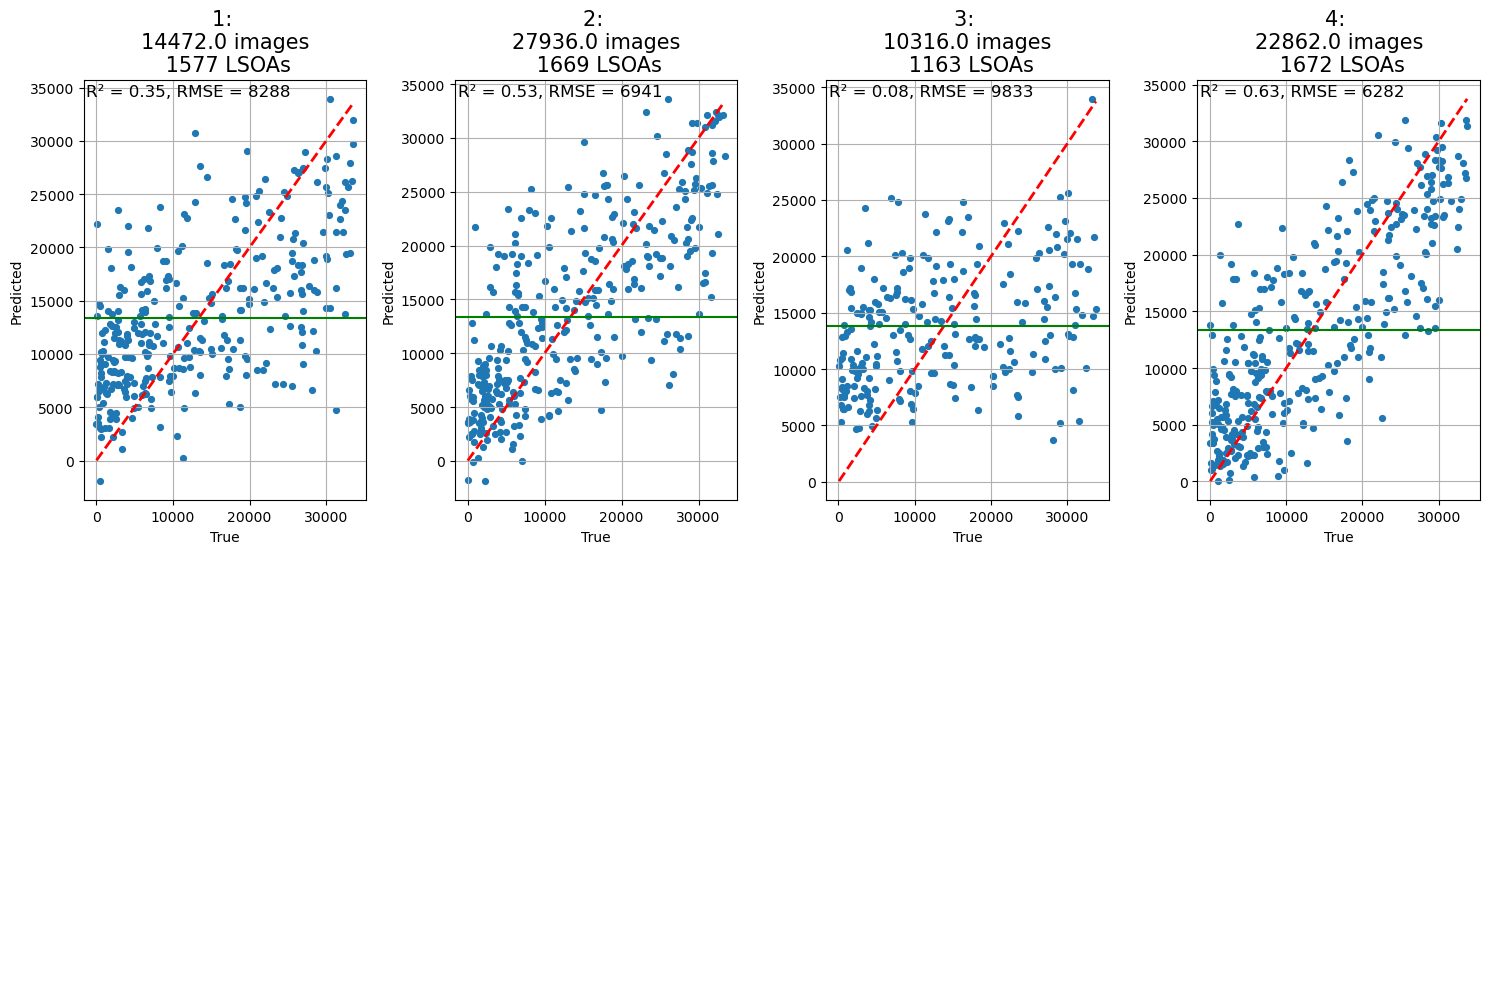

In [8]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 10))
axs = axs.flatten()

results_per_cluster = {}

for i, cluster_num in enumerate(range(1, k + 1)):

    # Clone the best model for each cluster (avoid contamination between clusters)
    model = clone(best_model)

    emb_col = f'{cluster_num}_{statistic}'
    count_col = f'count_{cluster_num}'

    one_image_type = summary_df_with_imd[["LSOA21CD", emb_col, count_col, var_to_predict]].copy()
    num_in_class = one_image_type[count_col].sum()

    # Drop LSOAs where this cluster has no images (embedding is NaN scalar)
    has_embedding = one_image_type[emb_col].apply(lambda x: not (isinstance(x, float) and np.isnan(x)))
    one_image_type = one_image_type[has_embedding].sort_values("LSOA21CD").reset_index(drop=True)
    num_lsoas = len(one_image_type)
    print(f"Cluster {cluster_num}: {num_lsoas} LSOAs, {num_in_class:.0f} images")

    # Build feature matrix from embeddings
    X = np.stack(one_image_type[emb_col].values)
    y = one_image_type[var_to_predict].values

    # 80/20 train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics = evaluate_imd_model(
        y_test, y_pred, cluster_num, num_in_class, num_lsoas,
        plot=False, plot_collectively=True, ax=axs[i])
    axs[i].axhline(y=one_image_type[var_to_predict].mean(), color='green', linestyle='-')

    results_per_cluster[cluster_num] = metrics

# Hide unused subplot axes
for j in range(i + 1, len(axs)):
    axs[j].axis("off")

fig.tight_layout()

### Get results for clusters as a table

In [9]:
pd.DataFrame(results_per_cluster)

,1,2,3,4
RMSE,8288.348931,6940.855279,9833.275344,6281.704227
MAE,6745.924805,5406.499023,8279.217773,4978.469238
R2,0.353048,0.528758,0.078631,0.625092
Spearman_rank_corr,0.587293,0.741962,0.351250,0.766018
